## ECG Dataset Exploration
**Cristiana Carpinteiro Solution**

In [38]:
import pandas as pd
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import ecg_plot
import heartpy as hp
from utils import load_raw_data, one_hot_encode_diagnosis, plot_fft, plot_pqrst, plot_pqrst_comparison
%matplotlib inline

## Metadata Analysis

In [2]:
path_to_data = 'data/physionet.org/'
metadata = pd.read_csv(os.path.join(path_to_data,'ptbxl_database.csv'), index_col='ecg_id')
scp_df = pd.read_csv(os.path.join(path_to_data,'scp_statements.csv'), index_col=0)
scp_df = scp_df[scp_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            tmp.append(scp_df.loc[key].diagnostic_class)
    return list(set(tmp))
## read scp codes 
metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))
metadata['diagnostic_superclass'] = metadata.scp_codes.apply(aggregate_diagnostic)
print("Metadata shape: ", metadata.shape) 
print("Columns: ", list(metadata.columns))

Metadata shape:  (21801, 44)
Columns:  ['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH', 'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC', 'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL', 'diagnostic_superclass']


We have 44 columns of metadata, including the age and sex of the patient and the recording device. According to the documentation of the dataset: 
"The dataset comprises 21837 clinical 12-lead ECG records of 10 seconds length from 18885 patients, where 52% are male and 48% are female with ages covering the whole range from 0 to 95 years (median 62 and interquantile range of 22). The value of the dataset results from the comprehensive collection of many different co-occurring pathologies, but also from a large proportion of healthy control samples. "

**Parse diagnosis SCP codes as one-hot encoded labels:**

In [3]:
code_summary, metadata = one_hot_encode_diagnosis(scp_df, metadata)
metadata.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,LPFB,LVH,NDT,NORM,NST_,PMI,RAO/RAE,RVH,SEHYP,WPW
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN


### Superclasses

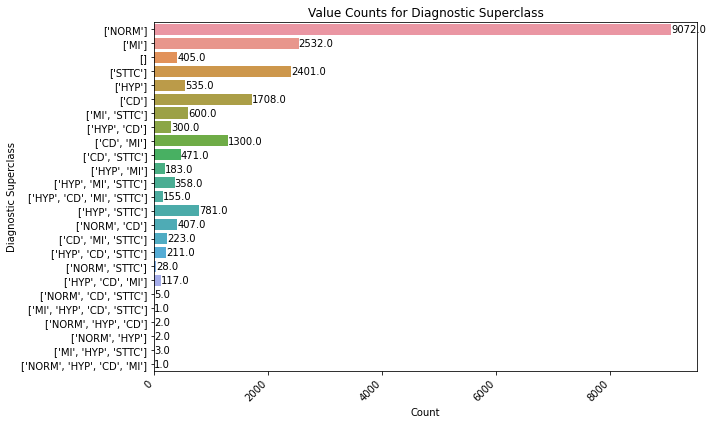

In [4]:
metadata['n_diagnostic'] = metadata['diagnostic_superclass'].apply(len)
metadata['diagnostic_superclass_str'] = metadata['diagnostic_superclass'].apply(str)
# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='diagnostic_superclass_str', data=metadata)
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('Count')
plt.ylabel('Diagnostic Superclass')
plt.title('Value Counts for Diagnostic Superclass')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

There are 5 superclasses. A patient can have more than 1 superclass associated, making this a multilabel problem.  

### Diagnostics

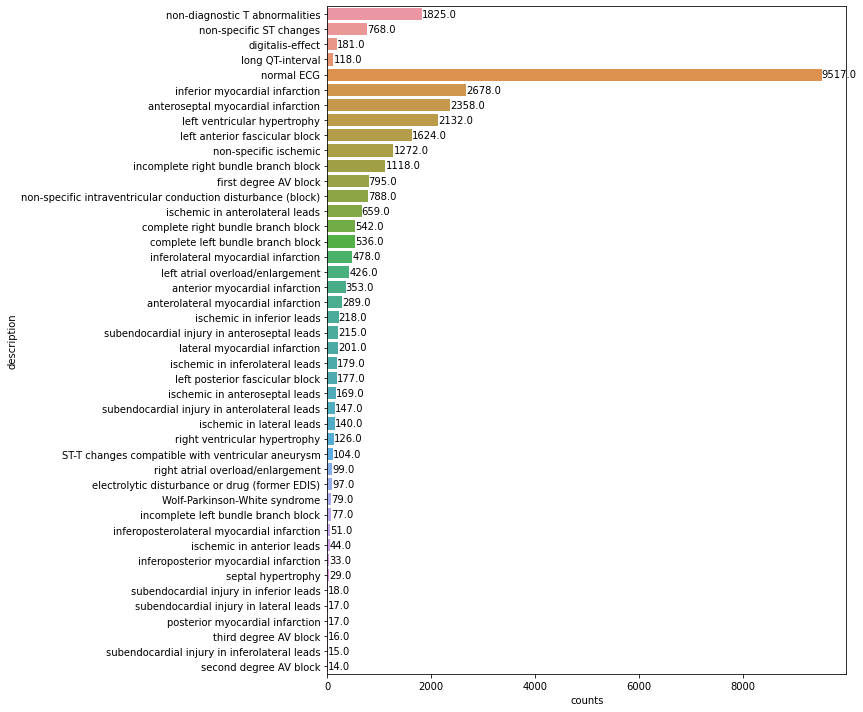

In [5]:
counts = code_summary.count().sort_values(ascending=False)
scp_df["counts"]= counts
plt.figure( figsize=(12,10))
ax = sns.barplot(data=scp_df, y="description", x="counts")
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.tight_layout()
plt.show()

There are 44 co-occuring pathologies in the dataset. Each of the pathologies belongs to 1 of 5 superclasses. The most common class is normal ECG. There are classes very underrepresented, with less than 50 patients in a dataset with more than 20000 patients total, which can make it difficult to identify using a machine learning model. 

We have a vast potential with this dataset. The development of machine learning models will depend on the specific objectives and the type of information we aim to provide to clinicians. A starting point could be to identify abnormal ECGs. By using normal patient data, we can establish a "baseline" of what a normal ECG waveform should look like and then identify when an ECG deviates from this "normal standard."

Performing direct classification of 41 different labels, especially with some underrepresented ones, can be challenging. This would result in a multiclass problem with a lot of classes, making it difficult to interpret the results. To address this, we could design a pipeline that first stratifies ECGs into broader superclasses, where ECGs could have more than one label (multilabel problem). This approach could serve as a helpful tool for physicians to triage patients. However, determining its feasibility requires domain expertise.

For instance, do all pathologies included in the MI (myocardial infarction) superclass exhibit similar waveforms? If not, this complexity could make the problem more challenging and result in sparse data difficult to predict. If we do intend to perform classification with 44 classes, there are methods to deal with unbalanced datasets, such as generating synthetic samples, dataset resampling, or acquiring more data. 
Another exciting machine learning approach could involve generating descriptions for ECGs using textual information (the description or the report columns). This would require an generative model that receives as an input the raw ECG signal and outputs a text caption ([look here](https://proceedings.mlr.press/v172/bartels22a.html)).

### Correlation with age and sex

<Axes: xlabel='n_diagnostic', ylabel='age'>

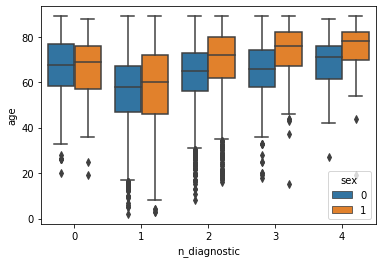

In [6]:
sns.boxplot(data=metadata[metadata.age<300],x="n_diagnostic", y="age", hue="sex")

The number of superclasses attributted to each patient seems to be correlated with age and sex. When balancing the cross-validation folds we should take this into account to remove these confounding factors. Different folds should have similar age and gender distribuitions. Since there this correlation of the age with the number of superclasses, we should be carefull about feeding metadata features to the model directly, because the model could use this information to stratify patients instead of looking into the waveforms.

### Acquisition devices

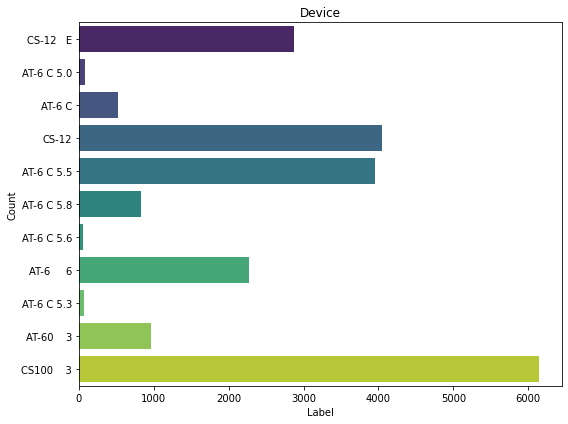

In [7]:
# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, y="device", palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Device')
plt.tight_layout()
plt.show()

The presence of several recording devices can be problematic, especially when some devices are underrepresented, which happens here. In such cases, the model may become biased towards the characteristics of the overrepresented devices. To address this issue, it is crucial to properly normalize the data and ensure that cross-validation folds are well-balanced, maintaining the same proportion as the training set (being aware that this balancing should be also made for different diseases within each device). From a machine learning perspective, there are various approaches to tackle this problem.

One approach is to train separate models for each device, but this approach is limited to only seen devices, and new recording devices would require building entirely new models.

Another approach is to use transfer learning, where a model is first trained on data from the most common devices and then fine-tuned on data from the less represented ones. This leverages the knowledge from the well-represented devices to improve performance on the less common ones.

The most robust solution is to apply **domain adaptation** during training. This type of training forces the model to discover common features across different devices and use them for predictions. 

To make an informed decision on which approach to use, it's essential to explore the precision and distribution of features from different devices, analyze the waveforms, frequency responses, calculate signal-to-noise-rations and identify if specific artifacts are associated with certain devices. 

# ECG analysis

In [8]:
sampling_rate=500
X = load_raw_data(metadata, path_to_data, sampling_rate )
print(X.shape)

(21801, 5000, 12)


#### Normal ECG

In [9]:
metadata= metadata.reset_index()
normal_patient_metadata = metadata[metadata.diagnostic_superclass_str=="['NORM']"]
normal_patient_metadata.head()
X_normal = X[normal_patient_metadata.index.values,:,:]

**Looking at one normal ECG example:**

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}


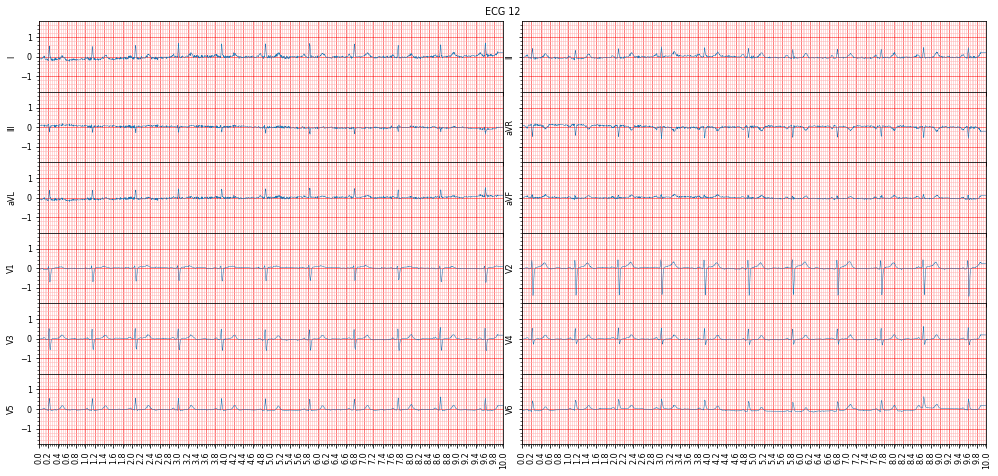

In [10]:
normal_patient_metadata.iloc[0].scp_codes
ecg_normal = X_normal[0].T
print(normal_patient_metadata.iloc[0].scp_codes)
ecg_plot.plot_12(ecg_normal, sample_rate = sampling_rate, title = 'ECG 12')

The ECG spans 10 seconds. There are 12 leads, which are placed in different parts of the body and can give the physician different information about the health of the heart. 

Lead II: Lead II is often considered important in monitoring and diagnosing arrhythmias, especially atrial fibrillation. It provides a good view of the electrical activity in the inferior part of the heart.

Lead V1 and V5: These chest leads are often crucial in diagnosing myocardial infarction (heart attack), particularly in the anterior and anterolateral regions of the heart.

Lead V4R: This right-sided chest lead is essential for diagnosing right ventricular infarction and other right ventricular abnormalities.

Lead V1 to V6: These chest leads collectively provide a comprehensive view of the electrical activity in the anterior, lateral, and left ventricular regions.

Lead aVR: Although not used for diagnostic purposes in isolation, aVR can sometimes help in identifying global abnormalities or high-risk patterns.

**Let's look closer at Lead II:**

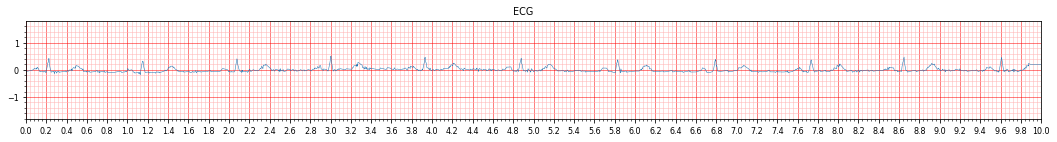

In [13]:
ecg_normal_lead2 = ecg_normal[1,:]
ecg_plot.plot_1(ecg_normal_lead2, sample_rate = sampling_rate, title = 'ECG')

**Identifying the heartbeat and plot it:**

/Users/ccarpinteiro/miniconda3/envs/idoven/lib/python3.9/site-packages/numpy/ma/core.py:5329: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/ccarpinteiro/miniconda3/envs/idoven/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


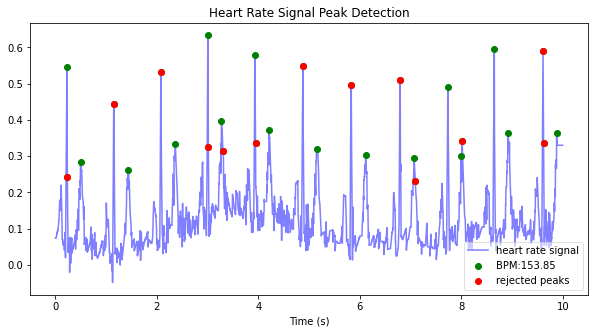

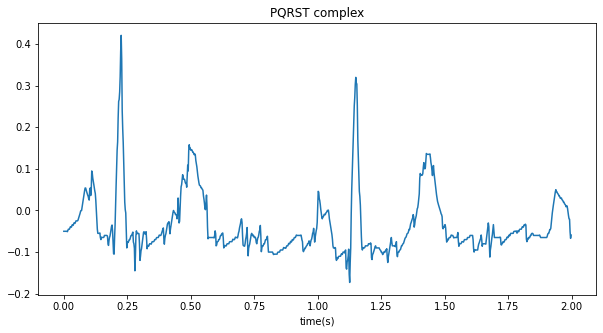

In [39]:
working_data, measures = hp.process(ecg_normal_lead2, sampling_rate)
hp.plotter(working_data, measures, figsize=(10,5))
plot_pqrst(ecg_normal_lead2)

You can clearly see the QRS complex, however the change in the baseline (probably caused by the respiration) is affecting the detection of the peaks and the calculation of heart beat. We can remove this by performing a high-pass or notch filter at a very low frequency(0.01 Hz), since the important information that makes the PQRST complex is encoded in low frequencies below 10 Hz.

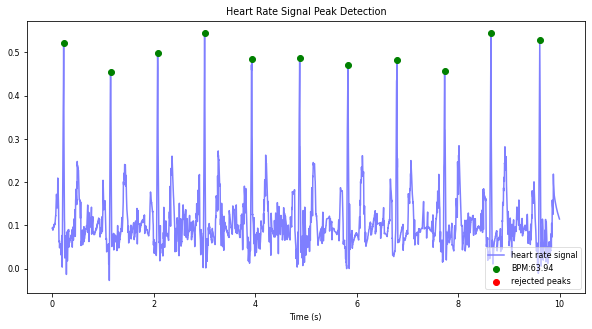

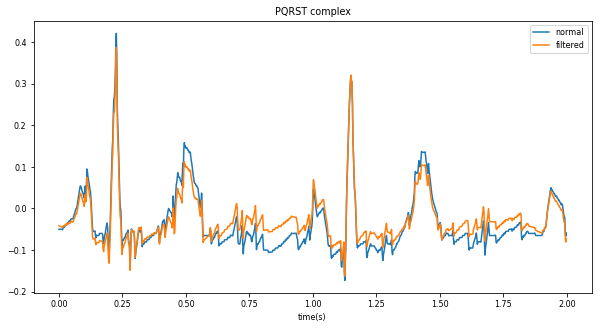

In [21]:
filtered_ecg_normal_lead2 = hp.remove_baseline_wander(ecg_normal_lead2,sampling_rate, cutoff=0.01)
working_data, measures = hp.process(filtered_ecg_normal_lead2, sampling_rate)
hp.plotter(working_data, measures, figsize=(10,5))
plot_pqrst_comparison(ecg_normal_lead2,filtered_ecg_normal_lead2, duration=2, sampling_rate=500, labels=["normal", "filtered"])

We corrected the baseline and the peaks are now well detected. The patient has an heart rate of 63.94 BPM. Looking closer at the PQRST complex it doesn't seem to be very affected by this filtering. There seems to be some small high frequency fluctuations affecting the signal.

**Let's look at the frequency response to inspect further:**

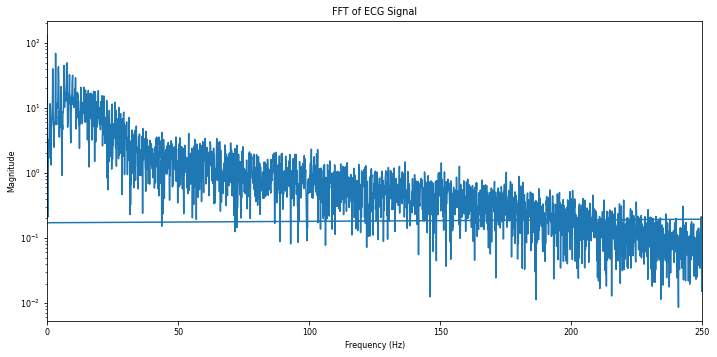

In [22]:
plot_fft(filtered_ecg_normal_lead2)

I cannot identify any visible peak that could be categorized as noise, like the AC noise at 50 or 60 Hz. One way to get a cleaner looking signal is applying a low-pass filter. Since the most important frequencies are below 100 Hz, we can apply a low-pass filter at that frequency to get a cleaner signal.

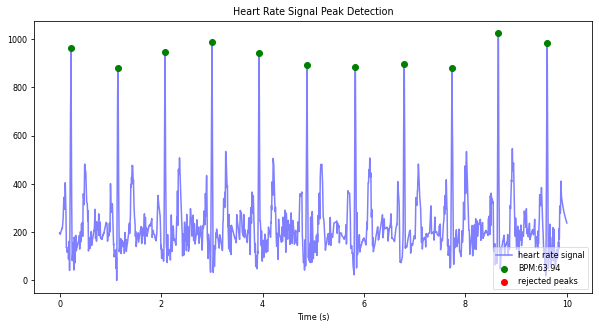

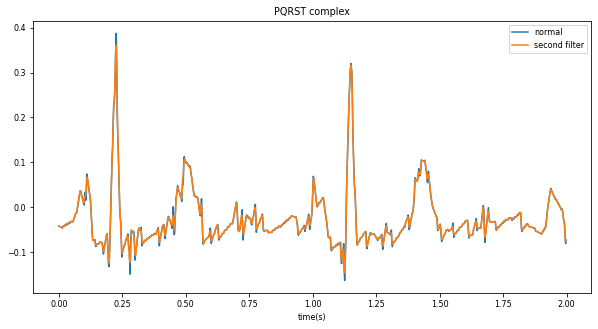

In [28]:
filtered_2_ecg_normal_lead2 = hp.filter_signal(filtered_ecg_normal_lead2,cutoff = 100, sample_rate=sampling_rate,filtertype="lowpass" )
working_data, measures = hp.process(hp.scale_data(filtered_2_ecg_normal_lead2), sampling_rate)
hp.plotter(working_data, measures, figsize=(10,5))
plot_pqrst_comparison(filtered_ecg_normal_lead2,filtered_2_ecg_normal_lead2, duration=2, sampling_rate=500, labels=["first filter", "second filter"])

It didn't make that much of a difference. So I'm gonna drop it for now.

### Pathology ECG
**Let's compare the normal ECG with a pathology one:**

In [29]:
mi_patient_metadata = metadata[metadata.diagnostic_superclass_str=="['MI']"]
mi_patient_metadata.head()
X_mi = X[mi_patient_metadata.index.values,:,:]

In [31]:
loc = 10
print(mi_patient_metadata.iloc[loc].scp_codes) 

{'IMI': 80.0, 'SR': 0.0}


This patient was diagnosed with inferior myocardial infarction with 80% likelihood. This patology is carachterized by ST segment elevation in the inferior leads (II, III and aVF) and reciprocal ST segment depression in the lateral and/or high lateral leads (I, aVL, V5 and V6).

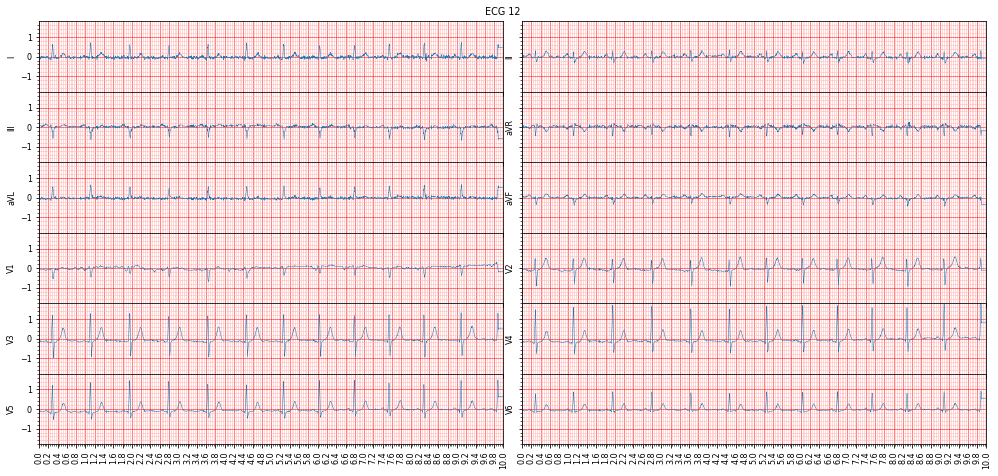

In [32]:
ecg_mi = X_mi[loc].T
ecg_plot.plot_12(ecg_mi, sample_rate = sampling_rate, title = 'ECG 12')

**Looking closer at lead II like we did for the healthy patient:**

/Users/ccarpinteiro/miniconda3/envs/idoven/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


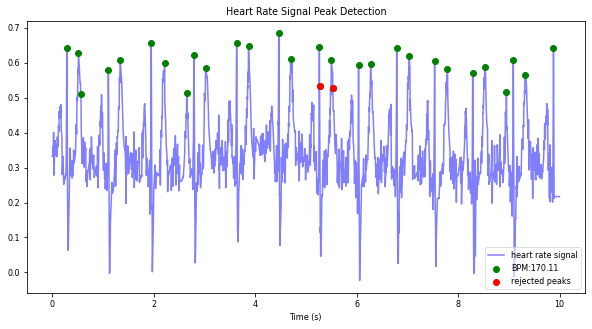

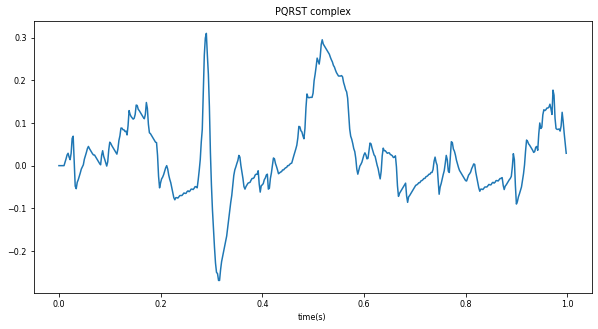

In [33]:
ecg_mi_lead2 = ecg_mi[1]
working_data, measures = hp.process(ecg_mi_lead2, sampling_rate)
hp.plotter(working_data, measures, figsize=(10, 5))
plot_pqrst(ecg_mi_lead2, duration=1)

The ST segment has as high magnitude as the R wave, like the description provided stated. The algorithm is detecting the T waves as the R peak and therefore giving us a wrong heartbeat. Correcting the baseline may help this problem.

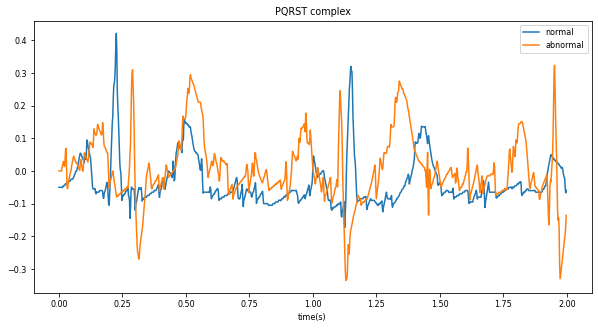

In [34]:
plot_pqrst_comparison(ecg_normal_lead2,ecg_mi_lead2)

Comparing the normal and abnormal ECGs we can better observe this. To better analyse this we should align the signals.

/Users/ccarpinteiro/miniconda3/envs/idoven/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


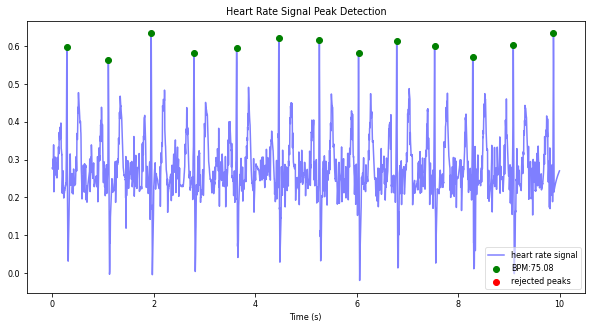

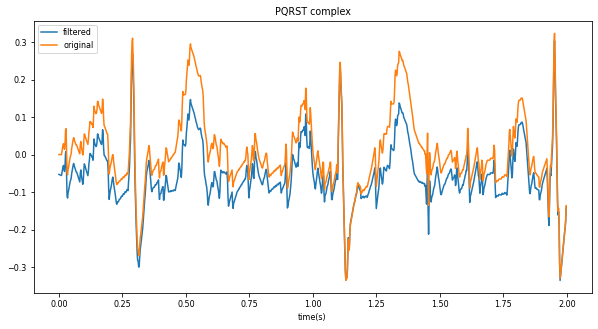

In [37]:
filtered_ecg_mi_lead2 = hp.remove_baseline_wander(ecg_mi_lead2,sampling_rate, cutoff=0.01)
working_data, measures = hp.process(filtered_ecg_mi_lead2, sampling_rate)
hp.plotter(working_data, measures, figsize=(10,5))
plot_pqrst_comparison(filtered_ecg_mi_lead2,ecg_mi_lead2, labels=["filtered", "original"])

Even though we can correctly identify the heartbeat now, this filtering has diminished the amplitude of the ST segments and "hide" the abnormality caused by the IMI. The filter applied had a cutoff frequency of 0.01 Hz, but maybe because the order was not high enough there was an unwanted attenuation of the low frequencies (like the fluctuation associated to the ST segment). 

## To wrap up 

The dataset complexity, with 44 diagnostic hypotheses, different recording devices, and multiple labels associated with the each patient, make it a challenging problem.Therefore, before proceeding with any model implementation, I would do a thorough analysis of the raw data.

The analysis would encompass several steps, including:

1. Normalizing the dataset to ensure that all signals fall within the same range.

2. Extracting the mean waveform of the PQRST complex for both healthy patients and each pathology and compare.

3. Tweaking the low-pass filter to preserve the slow waves while minimizing potential impacts on the signal.

4. Detecting and removing artifacts from the signal to enhance data quality.

5. Evaluating the signal-to-noise ratio of the different acquisition devices. 

6. Verifying if the stratification folds are well-balanced in terms of acquisition device, patient age, gender, superclass, and diagnosis.

In preparation for developing a deep learning architecture that automatically extracts features from the signal, I would manually extract features such as R-R Interval, P Wave Duration, PR Interval, QRS Complex Duration, and ST interval maximum amplitude. Using clustering and other simpler ML methods, I would evaluate the feasibility of capturing information from the signal and establish benchmarks. Additionally, I would do sanity checks, such as building a model to classify the device or shuffling labels and doing classification, to detect potential data biases and problems.

After ensuring the quality of the data, I would proceed to construct a deep learning architecture to automatically extract features and predict outcomes based on the requirements of the domain experts. I would do a literature review on current architectures applicable to time-series data, such as LSTM and transformer models, to guide my approach. Understanding better the patologies under study would be important to have a better understanding of the problem and facilitate communication with the domain experts. 
